### General TODOs:

---

In [32]:
import numpy              as np
import pandas             as pd
import seaborn            as sns
import matplotlib.pyplot  as plt
import random
import time
import datetime
import networkx           as nx

from   math               import ceil

from   experiments.indiv_u_side_exps_full import indiv_u_side_multiple_exp
from   experiments.indiv_u_side_exps_full import indiv_u_side_recalculation_exp
from   experiments.indiv_u_side_exps_full import indiv_u_side_delta_once_exp
from   experiments.indiv_u_side_exps_full import indiv_u_side_exp4

from   experiments.group_group_exps_full  import remove_best_k
from   experiments.group_group_exps_full  import calculate_best_k_deltas

from   utils.recwalk_funcs              import create_recwalk_model, create_recwalk_model_from_adj
from   utils.counterfactual             import ppr_absorbing_3, ppr_absorbing_5, calculate_lambda
from   model.user_item_dataset          import UserItemDataset
from   misc.dataset_stats               import plot_statistics

In [33]:
# PLOTTING CONFIGURATIONS
# enable inline plotting
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # set format to svg for better resolution
sns.set_theme() # apply seaborn default theme

## Matrix inversion to produce $p_x$ scores for every node x

In [34]:
def calculate_matrix_Q(P, gamma=0.15):
    return gamma*np.linalg.inv((np.identity(P.shape[0]) - (1-gamma)*P))

# Dataset loading
---

* Load a dataset
* Filter dataset to take a subset for genres **Action** and **Romance**

Male to Action: 0.6224642563066097
Female to Romance: 0.523059866962306


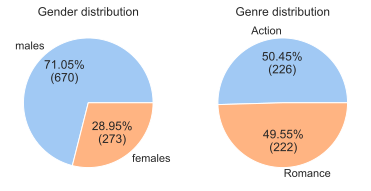

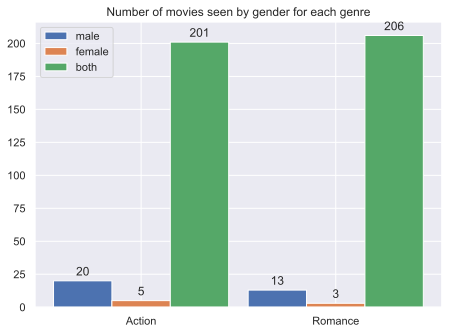

In [35]:
# Load dataset
my_dataset = UserItemDataset()
my_dataset.load_data(info_filepath='../datasets/ml-100k/u.info',
                     users_filepath='../datasets/ml-100k/u.user',
                     items_filepath='../datasets/ml-100k/u.item',
                     genres_filepath='../datasets/ml-100k/u.genre',
                     ratings_filepath='../datasets/ml-100k/u.data')

# my_dataset = UserItemDataset()
# my_dataset.load_data(info_filepath='../datasets/small_dataset_custom/u.info',
#                      users_filepath='../datasets/small_dataset_custom/u.user',
#                      items_filepath='../datasets/small_dataset_custom/u.item',
#                      genres_filepath='../datasets/small_dataset_custom/u.genre',
#                      ratings_filepath='../datasets/small_dataset_custom/u.data')


# Define genres of interest (I_0 and I_1)
genres_of_interest = ['Action', 'Romance']

# Note: i-th element of array user_original_ids corresponds to the real user-id (from 0 to n-1)
#       of user in i-th row of array R
user_original_ids, item_original_ids, R = my_dataset.filter_interactions_by_genre(genres_of_interest,
                                                                                  exclusive=True)
users_num, items_num = R.shape[0], R.shape[1]

# Seperate item group mapped ids for group 0 and group 1
item_group_mapped_ids_0, item_group_mapped_ids_1 = [], []
for i in range(item_original_ids.shape[0]):
    if my_dataset.is_genre(item_original_ids[i], genres_of_interest[0]):
        item_group_mapped_ids_0.append(i)
    else:
        item_group_mapped_ids_1.append(i)

# Transform to numpy arrays
item_group_mapped_ids_0, item_group_mapped_ids_1 = np.array(item_group_mapped_ids_0), np.array(item_group_mapped_ids_1)

# Find males mapped ids
male_mapped_ids = np.array([i for i in range(user_original_ids.shape[0]) if my_dataset.is_male(user_original_ids[i])])
female_mapped_ids = np.array([i for i in range(user_original_ids.shape[0]) if not my_dataset.is_male(user_original_ids[i])])

# Plot statistics about the subset of dataset
plot_statistics(dataset=my_dataset,
                genres=genres_of_interest,
                user_original_ids=user_original_ids,
                item_original_ids=item_original_ids,
                R=R)

# Individual-level explanations (user-side)

## Filter users

---

Get users with *at least 1* rating in both genres *at least 10* ratings total:

In [36]:
filtered_user_ids = np.array([user_id
                              for user_id in np.arange(users_num)
                              if ((np.count_nonzero(R[user_id, item_group_mapped_ids_0]) >= 1) &
                                  (np.count_nonzero(R[user_id, item_group_mapped_ids_1]) >= 1) &
                                  (np.count_nonzero(R[user_id, :]) >= 10))])

print(f"#users with >= 1 rating in both genres and >= 10 ratings overall: {filtered_user_ids.shape[0]}/{users_num}")
print(f"Males: {np.count_nonzero(np.in1d(filtered_user_ids, male_mapped_ids))}/{male_mapped_ids.shape[0]}")
print(f"Females: {np.count_nonzero(np.in1d(filtered_user_ids, female_mapped_ids))}/{female_mapped_ids.shape[0]}")

#users with >= 1 rating in both genres and >= 10 ratings overall: 739/943
Males: 540/670
Females: 199/273


## Calculate alpha and beta (in respect to Romance) (to be removed)

In [44]:
alpha = []
for user_id in filtered_user_ids:
    r_A = np.mean(R[user_id, item_group_mapped_ids_0])
    r_R = np.mean(R[user_id, item_group_mapped_ids_1])
    alpha.append(r_R/r_A)
alpha = np.array(alpha)

P = create_recwalk_model(R)
Q_u_to_i = calculate_matrix_Q(P)[:users_num, users_num:]

beta = []
for user_id in filtered_user_ids:
    p_u_A = np.mean(Q_u_to_i[user_id, item_group_mapped_ids_0])
    p_u_R = np.mean(Q_u_to_i[user_id, item_group_mapped_ids_1])
    beta.append(p_u_R/p_u_A)
    
beta = np.array(beta)

In [46]:
sample_size = 20

# alpha_inds = np.where((alpha >= 1 - epsilon) & (alpha <= 1 + epsilon))[0] # 50/50
# alpha_inds = np.where((alpha >= 1.5 - epsilon) & (alpha <= 1.5 + epsilon))[0] # 60/40
# sample_user_ids = filtered_user_ids[alpha_inds[np.argsort(beta_unseen[alpha_inds])]][:sample_size]

for user_id in sample_user_ids:
    print(f"id: {user_id}")
    r_A = np.count_nonzero(R[user_id, item_group_mapped_ids_0])
    r_R = np.count_nonzero(R[user_id, item_group_mapped_ids_1])
    print(f"r_A:{r_A}", end=' ')
    print(f"r_R:{r_R}", end=' ')
    print(f"({r_R/r_A})")
    p_u_A = np.sum(Q_u_to_i[user_id, item_group_mapped_ids_0])
    p_u_R = np.sum(Q_u_to_i[user_id, item_group_mapped_ids_1])
    print(f"(full) p_u_(A): {p_u_A}")
    print(f"(full) p_u_(R): {p_u_R}")
    print(f"(full) p_u_(R)/p_u_(A): ({p_u_R/p_u_A})")
    print('------')

id: 147
r_A:8 r_R:5 (0.625)
(full) p_u_(A): 0.273830984936283
(full) p_u_(R): 0.1856284745231765
(full) p_u_(R)/p_u_(A): (0.6778943389710623)
------
id: 371
r_A:11 r_R:7 (0.6363636363636364)
(full) p_u_(A): 0.2735693302686788
(full) p_u_(R): 0.18589012919078057
(full) p_u_(R)/p_u_(A): (0.6794991566057992)
------
id: 779
r_A:16 r_R:9 (0.5625)
(full) p_u_(A): 0.2735256821591829
(full) p_u_(R): 0.1859337773002765
(full) p_u_(R)/p_u_(A): (0.6797671642111807)
------
id: 159
r_A:21 r_R:13 (0.6190476190476191)
(full) p_u_(A): 0.2734588610711657
(full) p_u_(R): 0.1860005983882937
(full) p_u_(R)/p_u_(A): (0.6801776240115635)
------
id: 559
r_A:23 r_R:14 (0.6086956521739131)
(full) p_u_(A): 0.27341776289461533
(full) p_u_(R): 0.18604169656484412
(full) p_u_(R)/p_u_(A): (0.6804301761350854)
------
id: 431
r_A:14 r_R:9 (0.6428571428571429)
(full) p_u_(A): 0.273075684155145
(full) p_u_(R): 0.18638377530431438
(full) p_u_(R)/p_u_(A): (0.6825352315090144)
------
id: 926
r_A:30 r_R:20 (0.6666666666666

In [44]:
export_dir_path = './output/individual/test'
export_filename = 'exp1_5_a_50_50_b_40_60_full'
genre_absorbing_col = 1
directions_removed = 1

with open(f"{export_dir_path}/{export_filename}_details.tsv", 'w') as f:
    f.write('user_id\tr_R\tr_A\talpha\tbeta\n')
    for user_id in sample_user_ids:
        ind = np.where(filtered_user_ids == user_id)[0][0]
        f.write(f"{user_id}\t")
        f.write(f"{np.count_nonzero(R[user_id, item_group_mapped_ids_1])}\t")
        f.write(f"{np.count_nonzero(R[user_id, item_group_mapped_ids_0])}\t")
        f.write(f"{alpha[ind]}\t{beta_full[ind]}")
        
        if user_id != sample_user_ids[-1]: f.write('\n')

# indiv_u_side_multiple_exp(R                   = R,
    #                       user_original_ids   = user_original_ids,
    #                       item_original_ids   = item_original_ids,
    #                       item_group_mapped_ids_0 = item_group_mapped_ids_0,
    #                       item_group_mapped_ids_1 = item_group_mapped_ids_1,
    #                       genre_absorbing_col = genre_absorbing_col,
    #                       directions_removed  = directions_removed,
    #                       sample_users        = sample_user_ids,
    #                       export_filename     = export_filename,
    #                       export_dir_path     = export_dir_path)

### Experiment 1

In [7]:
sample_size = 50
genre_absorbing_col = 1
directions_removed = 1

sample_users_smallest = filtered_user_ids[np.argsort(beta)][:sample_size]
sample_users_largest = filtered_user_ids[np.argsort(beta)][::-1][:sample_size]

rng = np.random.default_rng(seed=1) # Give a seed to produce same sample
sample_users_random = rng.choice(filtered_user_ids, size=sample_size, replace=False)

In [8]:
export_dir_path ='./output/full/individual_user_side/exp1'
export_filename = f"exp1_{sample_size}_smallest_b"

indiv_u_side_multiple_exp(R                       = R,
                          user_original_ids       = user_original_ids,
                          item_original_ids       = item_original_ids,
                          item_group_mapped_ids_0 = item_group_mapped_ids_0,
                          item_group_mapped_ids_1 = item_group_mapped_ids_1,
                          genre_absorbing_col     = genre_absorbing_col,
                          directions_removed      = directions_removed,
                          sample_users            = sample_users_smallest,
                          export_filename         = export_filename,
                          export_dir_path         = export_dir_path)

[2023-03-15 16:18:04.805523] User 1 - id: 216:#neighbors=62
[2023-03-15 16:18:06.910457] 10 neighbors removed (refreshed per 10)
[2023-03-15 16:18:07.156280] 20 neighbors removed (refreshed per 10)
[2023-03-15 16:18:07.349170] 30 neighbors removed (refreshed per 10)
[2023-03-15 16:18:07.504117] 40 neighbors removed (refreshed per 10)
[2023-03-15 16:18:07.586041] 50 neighbors removed (refreshed per 10)
[2023-03-15 16:18:07.630017] 60 neighbors removed (refreshed per 10)
----------
[2023-03-15 16:18:07.632009] User 2 - id: 599:#neighbors=66
[2023-03-15 16:18:10.113586] 10 neighbors removed (refreshed per 10)
[2023-03-15 16:18:10.436400] 20 neighbors removed (refreshed per 10)
[2023-03-15 16:18:10.715241] 30 neighbors removed (refreshed per 10)
[2023-03-15 16:18:10.914161] 40 neighbors removed (refreshed per 10)
[2023-03-15 16:18:11.084027] 50 neighbors removed (refreshed per 10)
[2023-03-15 16:18:11.155992] 60 neighbors removed (refreshed per 10)
----------
[2023-03-15 16:18:11.166987] U

[2023-03-15 16:19:02.538507] 50 neighbors removed (refreshed per 10)
[2023-03-15 16:19:02.617463] 60 neighbors removed (refreshed per 10)
[2023-03-15 16:19:02.654449] 70 neighbors removed (refreshed per 10)
----------
[2023-03-15 16:19:02.655448] User 28 - id: 274:#neighbors=45
[2023-03-15 16:19:04.454443] 10 neighbors removed (refreshed per 10)
[2023-03-15 16:19:04.649299] 20 neighbors removed (refreshed per 10)
[2023-03-15 16:19:04.773225] 30 neighbors removed (refreshed per 10)
[2023-03-15 16:19:04.821205] 40 neighbors removed (refreshed per 10)
----------
[2023-03-15 16:19:04.829201] User 29 - id: 126:#neighbors=14
[2023-03-15 16:19:06.678168] 10 neighbors removed (refreshed per 10)
----------
[2023-03-15 16:19:06.685137] User 30 - id: 602:#neighbors=22
[2023-03-15 16:19:08.579077] 10 neighbors removed (refreshed per 10)
[2023-03-15 16:19:08.616056] 20 neighbors removed (refreshed per 10)
----------
[2023-03-15 16:19:08.617056] User 31 - id: 585:#neighbors=82
[2023-03-15 16:19:10.6

[2023-03-15 16:20:01.221840] 10 neighbors removed (refreshed per 10)
[2023-03-15 16:20:01.469733] 20 neighbors removed (refreshed per 10)
[2023-03-15 16:20:01.674588] 30 neighbors removed (refreshed per 10)
[2023-03-15 16:20:01.832525] 40 neighbors removed (refreshed per 10)
[2023-03-15 16:20:01.931441] 50 neighbors removed (refreshed per 10)
[2023-03-15 16:20:01.993433] 60 neighbors removed (refreshed per 10)
----------
Wall time: 1.9534 minutes


In [9]:
export_dir_path ='./output/full/individual_user_side/exp1'
export_filename = f"exp1_{sample_size}_largest_b"

indiv_u_side_multiple_exp(R                       = R,
                          user_original_ids       = user_original_ids,
                          item_original_ids       = item_original_ids,
                          item_group_mapped_ids_0 = item_group_mapped_ids_0,
                          item_group_mapped_ids_1 = item_group_mapped_ids_1,
                          genre_absorbing_col     = genre_absorbing_col,
                          directions_removed      = directions_removed,
                          sample_users            = sample_users_largest,
                          export_filename         = export_filename,
                          export_dir_path         = export_dir_path)

[2023-03-15 16:20:26.559377] User 1 - id: 584:#neighbors=17
[2023-03-15 16:20:28.313405] 10 neighbors removed (refreshed per 10)
----------
[2023-03-15 16:20:28.328397] User 2 - id: 476:#neighbors=26
[2023-03-15 16:20:30.084353] 10 neighbors removed (refreshed per 10)
[2023-03-15 16:20:30.142356] 20 neighbors removed (refreshed per 10)
----------
[2023-03-15 16:20:30.152316] User 3 - id: 761:#neighbors=14
[2023-03-15 16:20:31.704432] 10 neighbors removed (refreshed per 10)
----------
[2023-03-15 16:20:31.710420] User 4 - id: 873:#neighbors=12
[2023-03-15 16:20:33.339486] 10 neighbors removed (refreshed per 10)
----------
[2023-03-15 16:20:33.340486] User 5 - id: 903:#neighbors=35
[2023-03-15 16:20:35.006539] 10 neighbors removed (refreshed per 10)
[2023-03-15 16:20:35.097514] 20 neighbors removed (refreshed per 10)
[2023-03-15 16:20:35.142487] 30 neighbors removed (refreshed per 10)
----------
[2023-03-15 16:20:35.149484] User 6 - id: 706:#neighbors=59
[2023-03-15 16:20:36.888485] 10 n

[2023-03-15 16:21:34.784236] 10 neighbors removed (refreshed per 10)
[2023-03-15 16:21:34.876218] 20 neighbors removed (refreshed per 10)
[2023-03-15 16:21:34.949139] 30 neighbors removed (refreshed per 10)
----------
[2023-03-15 16:21:34.963168] User 39 - id: 859:#neighbors=25
[2023-03-15 16:21:36.569247] 10 neighbors removed (refreshed per 10)
[2023-03-15 16:21:36.615184] 20 neighbors removed (refreshed per 10)
----------
[2023-03-15 16:21:36.621181] User 40 - id: 614:#neighbors=32
[2023-03-15 16:21:38.462125] 10 neighbors removed (refreshed per 10)
[2023-03-15 16:21:38.546112] 20 neighbors removed (refreshed per 10)
[2023-03-15 16:21:38.579058] 30 neighbors removed (refreshed per 10)
----------
[2023-03-15 16:21:38.580057] User 41 - id: 184:#neighbors=12
[2023-03-15 16:21:40.177141] 10 neighbors removed (refreshed per 10)
----------
[2023-03-15 16:21:40.180148] User 42 - id: 590:#neighbors=32
[2023-03-15 16:21:41.831228] 10 neighbors removed (refreshed per 10)
[2023-03-15 16:21:41.9

In [9]:
export_dir_path ='./output/full/individual_user_side/exp1'
export_filename = f"exp1_{sample_size}_random"

indiv_u_side_multiple_exp(R                       = R,
                          user_original_ids       = user_original_ids,
                          item_original_ids       = item_original_ids,
                          item_group_mapped_ids_0 = item_group_mapped_ids_0,
                          item_group_mapped_ids_1 = item_group_mapped_ids_1,
                          genre_absorbing_col     = genre_absorbing_col,
                          directions_removed      = directions_removed,
                          sample_users            = sample_users_random,
                          export_filename         = export_filename,
                          export_dir_path         = export_dir_path)

[2023-03-10 17:53:38.825888] User 1 - id: 660:#neighbors=38
[2023-03-10 17:53:40.325478] 10 neighbors removed (refreshed per 10)
[2023-03-10 17:53:40.424448] 20 neighbors removed (refreshed per 10)
[2023-03-10 17:53:40.477382] 30 neighbors removed (refreshed per 10)
----------
[2023-03-10 17:53:40.492374] User 2 - id: 918:#neighbors=74
[2023-03-10 17:53:42.411282] 10 neighbors removed (refreshed per 10)
[2023-03-10 17:53:42.673528] 20 neighbors removed (refreshed per 10)
[2023-03-10 17:53:42.927382] 30 neighbors removed (refreshed per 10)
[2023-03-10 17:53:43.117263] 40 neighbors removed (refreshed per 10)
[2023-03-10 17:53:43.268212] 50 neighbors removed (refreshed per 10)
[2023-03-10 17:53:43.346168] 60 neighbors removed (refreshed per 10)
[2023-03-10 17:53:43.391114] 70 neighbors removed (refreshed per 10)
----------
[2023-03-10 17:53:43.396112] User 3 - id: 17:#neighbors=81
[2023-03-10 17:53:45.249954] 10 neighbors removed (refreshed per 10)
[2023-03-10 17:53:45.481822] 20 neighbor

[2023-03-10 17:54:31.041110] 60 neighbors removed (refreshed per 10)
[2023-03-10 17:54:31.401869] 70 neighbors removed (refreshed per 10)
[2023-03-10 17:54:31.738107] 80 neighbors removed (refreshed per 10)
[2023-03-10 17:54:32.018946] 90 neighbors removed (refreshed per 10)
[2023-03-10 17:54:32.257845] 100 neighbors removed (refreshed per 10)
[2023-03-10 17:54:32.441712] 110 neighbors removed (refreshed per 10)
[2023-03-10 17:54:32.606617] 120 neighbors removed (refreshed per 10)
[2023-03-10 17:54:32.712999] 130 neighbors removed (refreshed per 10)
[2023-03-10 17:54:32.769967] 140 neighbors removed (refreshed per 10)
----------
[2023-03-10 17:54:32.780961] User 23 - id: 770:#neighbors=29
[2023-03-10 17:54:34.394580] 10 neighbors removed (refreshed per 10)
[2023-03-10 17:54:34.462540] 20 neighbors removed (refreshed per 10)
----------
[2023-03-10 17:54:34.484528] User 24 - id: 459:#neighbors=22
[2023-03-10 17:54:36.028063] 10 neighbors removed (refreshed per 10)
[2023-03-10 17:54:36.07

[2023-03-10 17:55:27.530998] 30 neighbors removed (refreshed per 10)
[2023-03-10 17:55:27.630936] 40 neighbors removed (refreshed per 10)
[2023-03-10 17:55:27.687908] 50 neighbors removed (refreshed per 10)
[2023-03-10 17:55:27.710895] 60 neighbors removed (refreshed per 10)
----------
[2023-03-10 17:55:27.710895] User 46 - id: 59:#neighbors=60
[2023-03-10 17:55:28.903450] 10 neighbors removed (refreshed per 10)
[2023-03-10 17:55:29.017388] 20 neighbors removed (refreshed per 10)
[2023-03-10 17:55:29.106333] 30 neighbors removed (refreshed per 10)
[2023-03-10 17:55:29.186293] 40 neighbors removed (refreshed per 10)
[2023-03-10 17:55:29.228268] 50 neighbors removed (refreshed per 10)
----------
[2023-03-10 17:55:29.245254] User 47 - id: 300:#neighbors=116
[2023-03-10 17:55:30.169019] 10 neighbors removed (refreshed per 10)
[2023-03-10 17:55:30.342915] 20 neighbors removed (refreshed per 10)
[2023-03-10 17:55:30.640165] 30 neighbors removed (refreshed per 10)
[2023-03-10 17:55:31.023945]

### Experiment 2 - Algorithms comparison

* Delta with **multiple** edges
* Delta **recalculation**
* Delta calculation **once**

In [5]:
export_dir_path ='./output/full/individual_user_side/exp2'
export_filename = f"exp2_{sample_size}_random_multiple"

indiv_u_side_multiple_exp(R                       = R,
                          user_original_ids       = user_original_ids,
                          item_original_ids       = item_original_ids,
                          item_group_mapped_ids_0 = item_group_mapped_ids_0,
                          item_group_mapped_ids_1 = item_group_mapped_ids_1,
                          genre_absorbing_col     = genre_absorbing_col,
                          directions_removed      = directions_removed,
                          sample_users            = sample_users_random,
                          export_filename         = export_filename,
                          export_dir_path         = export_dir_path)

[2023-02-13 18:00:46.390935] User 1 - id: 79:#neighbors=10
----------
Wall time: 0.0325 minutes


In [8]:
export_dir_path = './output/full/individual_user_side/exp2'
export_filename = f"exp2_{sample_size}_random_recalculation"

indiv_u_side_recalculation_exp(R=R,
                               user_original_ids       = user_original_ids,
                               item_original_ids       = item_original_ids,
                               item_group_mapped_ids_0 = item_group_mapped_ids_0,
                               item_group_mapped_ids_1 = item_group_mapped_ids_1,
                               genre_absorbing_col     = genre_absorbing_col,
                               directions_removed      = directions_removed,
                               sample_users            = sample_users_random,
                               export_filename         = export_filename,
                               export_dir_path         = export_dir_path)

[2023-03-10 21:29:17.559021] User 1 - id: 660:#neighbors=38
[2023-03-10 21:29:32.218868] 10 neighbors removed. (refreshed per 10)
[2023-03-10 21:29:39.520025] 20 neighbors removed. (refreshed per 10)
[2023-03-10 21:29:53.438971] 30 neighbors removed. (refreshed per 10)
----------
[2023-03-10 21:30:05.011226] User 2 - id: 918:#neighbors=74
[2023-03-10 21:30:19.495126] 10 neighbors removed. (refreshed per 10)
[2023-03-10 21:30:31.449038] 20 neighbors removed. (refreshed per 10)
[2023-03-10 21:30:44.342704] 30 neighbors removed. (refreshed per 10)
[2023-03-10 21:30:59.274703] 40 neighbors removed. (refreshed per 10)
[2023-03-10 21:31:14.082523] 50 neighbors removed. (refreshed per 10)
[2023-03-10 21:31:27.985247] 60 neighbors removed. (refreshed per 10)
[2023-03-10 21:31:38.082115] 70 neighbors removed. (refreshed per 10)
----------
[2023-03-10 21:31:43.848506] User 3 - id: 17:#neighbors=81
[2023-03-10 21:31:59.253025] 10 neighbors removed. (refreshed per 10)
[2023-03-10 21:32:14.314443] 

[2023-03-10 21:52:07.550974] 30 neighbors removed. (refreshed per 10)
[2023-03-10 21:52:16.859983] 40 neighbors removed. (refreshed per 10)
[2023-03-10 21:52:32.509936] 50 neighbors removed. (refreshed per 10)
[2023-03-10 21:52:47.386883] 60 neighbors removed. (refreshed per 10)
[2023-03-10 21:53:03.048774] 70 neighbors removed. (refreshed per 10)
[2023-03-10 21:53:17.525885] 80 neighbors removed. (refreshed per 10)
[2023-03-10 21:53:30.722122] 90 neighbors removed. (refreshed per 10)
[2023-03-10 21:53:43.469359] 100 neighbors removed. (refreshed per 10)
[2023-03-10 21:53:57.331394] 110 neighbors removed. (refreshed per 10)
[2023-03-10 21:54:14.781437] 120 neighbors removed. (refreshed per 10)
[2023-03-10 21:54:29.651352] 130 neighbors removed. (refreshed per 10)
[2023-03-10 21:54:40.562492] 140 neighbors removed. (refreshed per 10)
----------
[2023-03-10 21:54:48.868570] User 23 - id: 770:#neighbors=29
[2023-03-10 21:55:03.323431] 10 neighbors removed. (refreshed per 10)
[2023-03-10 2

[2023-03-10 22:15:17.984637] 40 neighbors removed. (refreshed per 10)
[2023-03-10 22:15:31.538608] 50 neighbors removed. (refreshed per 10)
----------
[2023-03-10 22:15:37.935856] User 45 - id: 248:#neighbors=62
[2023-03-10 22:15:53.266469] 10 neighbors removed. (refreshed per 10)
[2023-03-10 22:16:07.696236] 20 neighbors removed. (refreshed per 10)
[2023-03-10 22:16:22.349155] 30 neighbors removed. (refreshed per 10)
[2023-03-10 22:16:33.434396] 40 neighbors removed. (refreshed per 10)
[2023-03-10 22:16:47.601763] 50 neighbors removed. (refreshed per 10)
[2023-03-10 22:17:01.799330] 60 neighbors removed. (refreshed per 10)
----------
[2023-03-10 22:17:04.623047] User 46 - id: 59:#neighbors=60
[2023-03-10 22:17:18.979223] 10 neighbors removed. (refreshed per 10)
[2023-03-10 22:17:30.349733] 20 neighbors removed. (refreshed per 10)
[2023-03-10 22:17:44.912706] 30 neighbors removed. (refreshed per 10)
[2023-03-10 22:18:00.126217] 40 neighbors removed. (refreshed per 10)
[2023-03-10 22:18

In [9]:
export_dir_path = './output/full/individual_user_side/exp2'
export_filename = f"exp2_{sample_size}_random_delta_once"

indiv_u_side_delta_once_exp(R=R,
                            user_original_ids       = user_original_ids,
                            item_original_ids       = item_original_ids,
                            item_group_mapped_ids_0 = item_group_mapped_ids_0,
                            item_group_mapped_ids_1 = item_group_mapped_ids_1,
                            genre_absorbing_col     = genre_absorbing_col,
                            directions_removed      = directions_removed,
                            sample_users            = sample_users_random,
                            export_filename         = export_filename,
                            export_dir_path         = export_dir_path)

[2023-03-10 22:29:31.359598] User 1 - id: 660:#neighbors=38
----------
[2023-03-10 22:30:08.301487] User 2 - id: 918:#neighbors=74
----------
[2023-03-10 22:30:59.565075] User 3 - id: 17:#neighbors=81
----------
[2023-03-10 22:31:27.620644] User 4 - id: 411:#neighbors=18
----------
[2023-03-10 22:31:43.974649] User 5 - id: 450:#neighbors=30
----------
[2023-03-10 22:31:56.158826] User 6 - id: 846:#neighbors=46
----------
[2023-03-10 22:32:28.484895] User 7 - id: 902:#neighbors=34
----------
[2023-03-10 22:32:59.040525] User 8 - id: 757:#neighbors=128
----------
[2023-03-10 22:34:28.726973] User 9 - id: 487:#neighbors=53
----------
[2023-03-10 22:35:16.139686] User 10 - id: 122:#neighbors=20
----------
[2023-03-10 22:35:20.539234] User 11 - id: 111:#neighbors=10
----------
[2023-03-10 22:35:28.764675] User 12 - id: 839:#neighbors=56
----------
[2023-03-10 22:36:03.208210] User 13 - id: 118:#neighbors=75
----------
[2023-03-10 22:37:20.180806] User 14 - id: 715:#neighbors=92
----------
[

## Experiment 4

Produce deltas to calculate correlation between delta and popularity

In [13]:
##### Experiment paramaters #####
sample_size = 300 #200
genre_absorbing_col = 1
export_dir_path = './output/full/individual_user_side/exp4'
export_filename = f"exp4_{sample_size}_random"
#################################

rng = np.random.default_rng(seed=1) # Give a seed to produce same sample
sample_users_random = rng.choice(filtered_user_ids, size=sample_size, replace=False)

indiv_u_side_exp4(R,
                  user_original_ids       = user_original_ids,
                  item_original_ids       = item_original_ids,
                  item_group_mapped_ids_0 = item_group_mapped_ids_0,
                  item_group_mapped_ids_1 = item_group_mapped_ids_1,
                  genre_absorbing_col     = genre_absorbing_col,
                  sample_users            = sample_users_random,
                  export_dir_path         = export_dir_path,
                  export_filename         = export_filename)

217 83


## Experiment 5

Remove best *nbs_to_remove* neighbors to calculate correlation between rank of removal and popularity.

In [11]:
sample_size = 300 #200
genre_absorbing_col = 1
directions_removed = 1
nbs_to_remove = 10

export_dir_path ='./output/full/individual_user_side/exp5'
export_filename = f"exp5_{sample_size}_random_best_{nbs_to_remove}"

rng = np.random.default_rng(seed=1) # Give a seed to produce same sample
sample_users_random = rng.choice(filtered_user_ids, size=sample_size, replace=False)

indiv_u_side_multiple_exp(R                       = R,
                          user_original_ids       = user_original_ids,
                          item_original_ids       = item_original_ids,
                          item_group_mapped_ids_0 = item_group_mapped_ids_0,
                          item_group_mapped_ids_1 = item_group_mapped_ids_1,
                          genre_absorbing_col     = genre_absorbing_col,
                          directions_removed      = directions_removed,
                          sample_users            = sample_users_random,
                          nbs_to_remove_limit     = nbs_to_remove,
                          export_dir_path         = export_dir_path,
                          export_filename         = export_filename)

[2023-03-15 17:39:41.585274] User 1 - id: 590:#neighbors=32
[2023-03-15 17:39:43.257313] 10 neighbors removed (refreshed per 10)
----------
[2023-03-15 17:39:43.258314] User 2 - id: 873:#neighbors=12
[2023-03-15 17:39:45.307139] 10 neighbors removed (refreshed per 10)
----------
[2023-03-15 17:39:45.307139] User 3 - id: 929:#neighbors=31
[2023-03-15 17:39:47.554885] 10 neighbors removed (refreshed per 10)
----------
[2023-03-15 17:39:47.555857] User 4 - id: 863:#neighbors=109
[2023-03-15 17:39:50.001450] 10 neighbors removed (refreshed per 10)
----------
[2023-03-15 17:39:50.001450] User 5 - id: 869:#neighbors=80
[2023-03-15 17:39:52.386084] 10 neighbors removed (refreshed per 10)
----------
[2023-03-15 17:39:52.386084] User 6 - id: 634:#neighbors=15
[2023-03-15 17:39:54.064124] 10 neighbors removed (refreshed per 10)
----------
[2023-03-15 17:39:54.064124] User 7 - id: 828:#neighbors=27
[2023-03-15 17:39:55.787126] 10 neighbors removed (refreshed per 10)
----------
[2023-03-15 17:39:5

[2023-03-15 17:41:19.328592] 10 neighbors removed (refreshed per 10)
----------
[2023-03-15 17:41:19.328592] User 62 - id: 879:#neighbors=139
[2023-03-15 17:41:20.620851] 10 neighbors removed (refreshed per 10)
----------
[2023-03-15 17:41:20.620851] User 63 - id: 391:#neighbors=30
[2023-03-15 17:41:21.612283] 10 neighbors removed (refreshed per 10)
----------
[2023-03-15 17:41:21.612283] User 64 - id: 449:#neighbors=177
[2023-03-15 17:41:22.486781] 10 neighbors removed (refreshed per 10)
----------
[2023-03-15 17:41:22.486781] User 65 - id: 745:#neighbors=43
[2023-03-15 17:41:23.160394] 10 neighbors removed (refreshed per 10)
----------
[2023-03-15 17:41:23.160394] User 66 - id: 657:#neighbors=19
[2023-03-15 17:41:23.803025] 10 neighbors removed (refreshed per 10)
----------
[2023-03-15 17:41:23.803025] User 67 - id: 706:#neighbors=59
[2023-03-15 17:41:24.357706] 10 neighbors removed (refreshed per 10)
----------
[2023-03-15 17:41:24.357706] User 68 - id: 52:#neighbors=12
[2023-03-15 

----------
[2023-03-15 17:42:52.932873] User 123 - id: 602:#neighbors=22
[2023-03-15 17:42:53.899323] 10 neighbors removed (refreshed per 10)
----------
[2023-03-15 17:42:53.899323] User 124 - id: 182:#neighbors=33
[2023-03-15 17:42:54.732843] 10 neighbors removed (refreshed per 10)
----------
[2023-03-15 17:42:54.733844] User 125 - id: 839:#neighbors=56
[2023-03-15 17:42:55.838215] 10 neighbors removed (refreshed per 10)
----------
[2023-03-15 17:42:55.838215] User 126 - id: 502:#neighbors=65
[2023-03-15 17:42:57.552232] 10 neighbors removed (refreshed per 10)
----------
[2023-03-15 17:42:57.552232] User 127 - id: 393:#neighbors=72
[2023-03-15 17:42:59.047370] 10 neighbors removed (refreshed per 10)
----------
[2023-03-15 17:42:59.048370] User 128 - id: 730:#neighbors=30
[2023-03-15 17:43:00.060783] 10 neighbors removed (refreshed per 10)
----------
[2023-03-15 17:43:00.061783] User 129 - id: 516:#neighbors=20
[2023-03-15 17:43:01.561931] 10 neighbors removed (refreshed per 10)
------

[2023-03-15 17:44:23.843719] 10 neighbors removed (refreshed per 10)
----------
[2023-03-15 17:44:23.843719] User 185 - id: 928:#neighbors=18
[2023-03-15 17:44:24.992058] 10 neighbors removed (refreshed per 10)
----------
[2023-03-15 17:44:24.993057] User 186 - id: 71:#neighbors=52
[2023-03-15 17:44:25.997485] 10 neighbors removed (refreshed per 10)
----------
[2023-03-15 17:44:25.997485] User 187 - id: 156:#neighbors=25
[2023-03-15 17:44:26.772035] 10 neighbors removed (refreshed per 10)
----------
[2023-03-15 17:44:26.772035] User 188 - id: 370:#neighbors=25
[2023-03-15 17:44:27.456643] 10 neighbors removed (refreshed per 10)
----------
[2023-03-15 17:44:27.456643] User 189 - id: 714:#neighbors=81
[2023-03-15 17:44:28.062316] 10 neighbors removed (refreshed per 10)
----------
[2023-03-15 17:44:28.062316] User 190 - id: 248:#neighbors=62
[2023-03-15 17:44:28.677945] 10 neighbors removed (refreshed per 10)
----------
[2023-03-15 17:44:28.677945] User 191 - id: 513:#neighbors=68
[2023-0

[2023-03-15 17:45:33.845584] 10 neighbors removed (refreshed per 10)
----------
[2023-03-15 17:45:33.846585] User 244 - id: 939:#neighbors=29
[2023-03-15 17:45:35.520623] 10 neighbors removed (refreshed per 10)
----------
[2023-03-15 17:45:35.520623] User 245 - id: 435:#neighbors=41
[2023-03-15 17:45:37.146685] 10 neighbors removed (refreshed per 10)
----------
[2023-03-15 17:45:37.147683] User 246 - id: 601:#neighbors=12
[2023-03-15 17:45:38.784747] 10 neighbors removed (refreshed per 10)
----------
[2023-03-15 17:45:38.784747] User 247 - id: 19:#neighbors=17
[2023-03-15 17:45:40.369834] 10 neighbors removed (refreshed per 10)
----------
[2023-03-15 17:45:40.369834] User 248 - id: 80:#neighbors=21
[2023-03-15 17:45:41.829004] 10 neighbors removed (refreshed per 10)
----------
[2023-03-15 17:45:41.829004] User 249 - id: 458:#neighbors=54
[2023-03-15 17:45:43.539023] 10 neighbors removed (refreshed per 10)
----------
[2023-03-15 17:45:43.539023] User 250 - id: 782:#neighbors=10
--------

## Experiment 6: How many items we need to remove to achieve specific increase

In [51]:
# Users selection
sample_size = 20

# alpha_inds = np.where((alpha >= 1 - epsilon) & (alpha <= 1 + epsilon))[0] # 50/50
# sample_users = filtered_user_ids[alpha_inds[np.argsort(beta[alpha_inds])]][:sample_size]

# beta_inds = np.where((beta >= 0.69) & (beta <= 0.71))[0]
# sample_users = filtered_user_ids[beta_inds[np.argsort(beta[beta_inds])]][:sample_size]

# beta_inds = np.where((beta >= 0.79) & (beta <= 0.81))[0]
# sample_users = filtered_user_ids[beta_inds[np.argsort(beta[beta_inds])]][:sample_size]

beta_inds = np.where((beta >= 0.88) & (beta <= 0.92))[0]
sample_users = filtered_user_ids[beta_inds[np.argsort(beta[beta_inds])]][:sample_size]

# Experiment variables
export_dir_path = './output/full/individual_user_side/exp6'
# export_filename = f"exp6_{sample_size}_a_1"
# export_filename = f"exp6_{sample_size}_b_0.7"
# export_filename = f"exp6_{sample_size}_b_0.8"
export_filename = f"exp6_{sample_size}_b_0.9"

genre_absorbing_col = 1
directions_removed = 1

# Write details
with open(f"{export_dir_path}/{export_filename}_details.tsv", 'w') as f:
    f.write('user_id\tr_R\tr_A\talpha\tbeta\n')
    for user_id in sample_users:
        ind = np.where(filtered_user_ids == user_id)[0][0]
        f.write(f"{user_id}\t")
        f.write(f"{np.mean(R[user_id, item_group_mapped_ids_1])}\t")
        f.write(f"{np.mean(R[user_id, item_group_mapped_ids_0])}\t")
        f.write(f"{alpha[ind]}\t{beta[ind]}")
        
        if user_id != sample_users[-1]: f.write('\n')

indiv_u_side_multiple_exp(R                       = R,
                          user_original_ids       = user_original_ids,
                          item_original_ids       = item_original_ids,
                          item_group_mapped_ids_0 = item_group_mapped_ids_0,
                          item_group_mapped_ids_1 = item_group_mapped_ids_1,
                          genre_absorbing_col     = genre_absorbing_col,
                          directions_removed      = directions_removed,
                          sample_users            = sample_users,
                          export_filename         = export_filename,
                          export_dir_path         = export_dir_path)

[2023-04-01 15:12:03.045736] User 1 - id: 13:#neighbors=27
[2023-04-01 15:12:05.349440] 10 neighbors removed (refreshed per 10)
[2023-04-01 15:12:05.410406] 20 neighbors removed (refreshed per 10)
----------
[2023-04-01 15:12:05.423397] User 2 - id: 697:#neighbors=52
[2023-04-01 15:12:07.523204] 10 neighbors removed (refreshed per 10)
[2023-04-01 15:12:07.701102] 20 neighbors removed (refreshed per 10)
[2023-04-01 15:12:07.830036] 30 neighbors removed (refreshed per 10)
[2023-04-01 15:12:07.911982] 40 neighbors removed (refreshed per 10)
[2023-04-01 15:12:07.940966] 50 neighbors removed (refreshed per 10)
----------
[2023-04-01 15:12:07.941966] User 3 - id: 473:#neighbors=96
[2023-04-01 15:12:10.275681] 10 neighbors removed (refreshed per 10)
[2023-04-01 15:12:10.609465] 20 neighbors removed (refreshed per 10)
[2023-04-01 15:12:11.081197] 30 neighbors removed (refreshed per 10)
[2023-04-01 15:12:11.486967] 40 neighbors removed (refreshed per 10)
[2023-04-01 15:12:11.748823] 50 neighbor

# Group-level explanations

---

## Experiment 1

In [5]:
# sample_size = [5, 10, 20, 40, 80, 400]
# k_nbs = [80, 40, 20, 10, 5, 1]
sample_size = [400]
k_nbs = [1]
nbs_per_round = 20
genre_absorbing_col = 1
export_dir_path = './output/full/group_group/exp1'

P = create_recwalk_model(R)
Q_u_to_u = calculate_matrix_Q(P)[:users_num, :users_num]

p_U_0_u_males = np.mean(Q_u_to_u[male_mapped_ids, :], axis=0)[male_mapped_ids]

for s, k in zip(sample_size, k_nbs):
    sample_users = male_mapped_ids[np.argsort(p_U_0_u_males)[::-1]][:s]
    
    export_filename = f'exp1_{s}_{k}_males_{nbs_per_round}'

    print(f"Experiment for {s} users - {k} nbs started..")
    remove_best_k(R                       = R,
                  user_original_ids       = user_original_ids,
                  item_original_ids       = item_original_ids,
                  user_group_mapped_ids   = male_mapped_ids,
                  item_group_mapped_ids_0 = item_group_mapped_ids_0,
                  item_group_mapped_ids_1 = item_group_mapped_ids_1,
                  sample_users            = sample_users,
                  k_nbs                   = k,
                  genre_absorbing_col     = genre_absorbing_col,
                  nbs_per_round           = nbs_per_round,
                  export_dir_path         = export_dir_path,
                  export_filename         = export_filename)
    print(f"Experiment ended..")

Experiment for 400 users - 1 nbs started..
[2023-03-26 19:02:00.613544] User 1 - id: 12:#neighbors=221
[2023-03-26 19:02:01.300124] User 2 - id: 275:#neighbors=180
[2023-03-26 19:02:01.930733] User 3 - id: 302:#neighbors=177
[2023-03-26 19:02:02.579401] User 4 - id: 392:#neighbors=168
[2023-03-26 19:02:03.183449] User 5 - id: 726:#neighbors=159
[2023-03-26 19:02:03.803127] User 6 - id: 278:#neighbors=159
[2023-03-26 19:02:04.374164] User 7 - id: 681:#neighbors=151
[2023-03-26 19:02:04.931820] User 8 - id: 536:#neighbors=140
[2023-03-26 19:02:05.511492] User 9 - id: 221:#neighbors=146
[2023-03-26 19:02:06.096162] User 10 - id: 129:#neighbors=139
[2023-03-26 19:02:06.638281] User 11 - id: 428:#neighbors=143
[2023-03-26 19:02:07.197400] User 12 - id: 895:#neighbors=140
[2023-03-26 19:02:07.748089] User 13 - id: 377:#neighbors=140
[2023-03-26 19:02:08.337150] User 14 - id: 879:#neighbors=139
[2023-03-26 19:02:08.926807] User 15 - id: 91:#neighbors=140
[2023-03-26 19:02:09.542460] User 16 -

[2023-03-26 19:03:17.442769] User 134 - id: 670:#neighbors=72
[2023-03-26 19:03:17.989465] User 135 - id: 931:#neighbors=71
[2023-03-26 19:03:18.568567] User 136 - id: 196:#neighbors=66
[2023-03-26 19:03:19.160236] User 137 - id: 41:#neighbors=70
[2023-03-26 19:03:19.947790] User 138 - id: 520:#neighbors=67
[2023-03-26 19:03:20.570433] User 139 - id: 455:#neighbors=68
[2023-03-26 19:03:21.102168] User 140 - id: 378:#neighbors=67
[2023-03-26 19:03:21.602306] User 141 - id: 842:#neighbors=68
[2023-03-26 19:03:22.144999] User 142 - id: 824:#neighbors=63
[2023-03-26 19:03:22.644070] User 143 - id: 896:#neighbors=67
[2023-03-26 19:03:23.183216] User 144 - id: 737:#neighbors=67
[2023-03-26 19:03:23.688903] User 145 - id: 21:#neighbors=67
[2023-03-26 19:03:24.232021] User 146 - id: 805:#neighbors=64
[2023-03-26 19:03:24.737727] User 147 - id: 446:#neighbors=63
[2023-03-26 19:03:25.283822] User 148 - id: 441:#neighbors=66
[2023-03-26 19:03:25.785503] User 149 - id: 248:#neighbors=62
[2023-03-2

[2023-03-26 19:04:32.216573] User 267 - id: 335:#neighbors=40
[2023-03-26 19:04:32.712293] User 268 - id: 322:#neighbors=32
[2023-03-26 19:04:33.223396] User 269 - id: 526:#neighbors=36
[2023-03-26 19:04:33.725113] User 270 - id: 723:#neighbors=26
[2023-03-26 19:04:34.234242] User 271 - id: 238:#neighbors=35
[2023-03-26 19:04:34.733960] User 272 - id: 250:#neighbors=35
[2023-03-26 19:04:35.272627] User 273 - id: 614:#neighbors=32
[2023-03-26 19:04:35.767340] User 274 - id: 391:#neighbors=30
[2023-03-26 19:04:36.366001] User 275 - id: 922:#neighbors=33
[2023-03-26 19:04:36.916690] User 276 - id: 159:#neighbors=34
[2023-03-26 19:04:37.489373] User 277 - id: 477:#neighbors=35
[2023-03-26 19:04:38.002075] User 278 - id: 421:#neighbors=30
[2023-03-26 19:04:38.508195] User 279 - id: 827:#neighbors=31
[2023-03-26 19:04:39.065880] User 280 - id: 889:#neighbors=34
[2023-03-26 19:04:39.595946] User 281 - id: 7:#neighbors=34
[2023-03-26 19:04:40.226595] User 282 - id: 902:#neighbors=34
[2023-03-2

[2023-03-26 19:06:00.884508] User 400 - id: 688:#neighbors=18
[2023-03-26 19:06:04.346936] Round 1/400 completed.
[2023-03-26 19:06:05.763587] Round 2/400 completed.
[2023-03-26 19:06:07.304568] Round 3/400 completed.
[2023-03-26 19:06:08.781207] Round 4/400 completed.
[2023-03-26 19:06:10.297235] Round 5/400 completed.
[2023-03-26 19:06:11.808373] Round 6/400 completed.
[2023-03-26 19:06:13.297464] Round 7/400 completed.
[2023-03-26 19:06:14.884034] Round 8/400 completed.
[2023-03-26 19:06:16.271105] Round 9/400 completed.
[2023-03-26 19:06:17.628716] Round 10/400 completed.
[2023-03-26 19:06:19.031386] Round 11/400 completed.
[2023-03-26 19:06:20.450501] Round 12/400 completed.
[2023-03-26 19:06:21.835230] Round 13/400 completed.
[2023-03-26 19:06:23.424146] Round 14/400 completed.
[2023-03-26 19:06:24.855343] Round 15/400 completed.
[2023-03-26 19:06:26.267412] Round 16/400 completed.
[2023-03-26 19:06:27.582181] Round 17/400 completed.
[2023-03-26 19:06:28.912821] Round 18/400 comp

[2023-03-26 19:09:47.643120] Round 154/400 completed.
[2023-03-26 19:09:49.627992] Round 155/400 completed.
[2023-03-26 19:09:51.315862] Round 156/400 completed.
[2023-03-26 19:09:53.095269] Round 157/400 completed.
[2023-03-26 19:09:54.720721] Round 158/400 completed.
[2023-03-26 19:09:56.039329] Round 159/400 completed.
[2023-03-26 19:09:57.040071] Round 160/400 completed.
[2023-03-26 19:09:57.735063] Round 161/400 completed.
[2023-03-26 19:09:58.294929] Round 162/400 completed.
[2023-03-26 19:09:59.617405] Round 163/400 completed.
[2023-03-26 19:10:00.988617] Round 164/400 completed.
[2023-03-26 19:10:02.455786] Round 165/400 completed.
[2023-03-26 19:10:03.956440] Round 166/400 completed.
[2023-03-26 19:10:05.501518] Round 167/400 completed.
[2023-03-26 19:10:06.911684] Round 168/400 completed.
[2023-03-26 19:10:08.452251] Round 169/400 completed.
[2023-03-26 19:10:09.935068] Round 170/400 completed.
[2023-03-26 19:10:11.398688] Round 171/400 completed.
[2023-03-26 19:10:12.813393]

[2023-03-26 19:13:23.766927] Round 306/400 completed.
[2023-03-26 19:13:25.407848] Round 307/400 completed.
[2023-03-26 19:13:26.955966] Round 308/400 completed.
[2023-03-26 19:13:28.440134] Round 309/400 completed.
[2023-03-26 19:13:29.845015] Round 310/400 completed.
[2023-03-26 19:13:31.603438] Round 311/400 completed.
[2023-03-26 19:13:33.375435] Round 312/400 completed.
[2023-03-26 19:13:34.897092] Round 313/400 completed.
[2023-03-26 19:13:36.565150] Round 314/400 completed.
[2023-03-26 19:13:38.048304] Round 315/400 completed.
[2023-03-26 19:13:39.703336] Round 316/400 completed.
[2023-03-26 19:13:41.207889] Round 317/400 completed.
[2023-03-26 19:13:42.898961] Round 318/400 completed.
[2023-03-26 19:13:44.445487] Round 319/400 completed.
[2023-03-26 19:13:45.892190] Round 320/400 completed.
[2023-03-26 19:13:47.290856] Round 321/400 completed.
[2023-03-26 19:13:48.796447] Round 322/400 completed.
[2023-03-26 19:13:50.241967] Round 323/400 completed.
[2023-03-26 19:13:51.560696]

Make above experiment for ALL males (with at least 1 rating in both genres)

In [7]:
export_dir_path = './output/full/group_group/exp1'
sample_users = male_mapped_ids[np.nonzero(
                    (np.count_nonzero(R[male_mapped_ids[:, np.newaxis], item_group_mapped_ids_0], axis=1) >= 1) &
                    (np.count_nonzero(R[male_mapped_ids[:, np.newaxis], item_group_mapped_ids_1], axis=1) >= 1))[0]]
k_nbs = 1
genre_absorbing_col = 1
nbs_per_round = 20

export_filename = f'exp1_{sample_users.shape[0]}_{k}_males_{nbs_per_round}'

remove_best_k(R                       = R,
              user_original_ids       = user_original_ids,
              item_original_ids       = item_original_ids,
              user_group_mapped_ids   = male_mapped_ids,
              item_group_mapped_ids_0 = item_group_mapped_ids_0,
              item_group_mapped_ids_1 = item_group_mapped_ids_1,
              sample_users            = sample_users,
              k_nbs                   = k,
              genre_absorbing_col     = genre_absorbing_col,
              nbs_per_round           = nbs_per_round,
              export_dir_path         = export_dir_path,
              export_filename         = export_filename)

[2023-03-26 19:48:53.507288] User 1 - id: 0:#neighbors=99
[2023-03-26 19:48:54.141929] User 2 - id: 2:#neighbors=15
[2023-03-26 19:48:54.610696] User 3 - id: 3:#neighbors=7
[2023-03-26 19:48:55.208360] User 4 - id: 5:#neighbors=60
[2023-03-26 19:48:55.754056] User 5 - id: 6:#neighbors=125
[2023-03-26 19:48:56.474647] User 6 - id: 7:#neighbors=34
[2023-03-26 19:48:57.123281] User 7 - id: 8:#neighbors=8
[2023-03-26 19:48:57.807445] User 8 - id: 9:#neighbors=51
[2023-03-26 19:48:58.469550] User 9 - id: 12:#neighbors=221
[2023-03-26 19:48:59.076232] User 10 - id: 13:#neighbors=27
[2023-03-26 19:48:59.576320] User 11 - id: 15:#neighbors=45
[2023-03-26 19:49:00.137003] User 12 - id: 16:#neighbors=9
[2023-03-26 19:49:00.649148] User 13 - id: 18:#neighbors=8
[2023-03-26 19:49:01.173879] User 14 - id: 20:#neighbors=48
[2023-03-26 19:49:01.687589] User 15 - id: 21:#neighbors=67
[2023-03-26 19:49:02.301650] User 16 - id: 24:#neighbors=22
[2023-03-26 19:49:02.817359] User 17 - id: 25:#neighbors=43

[2023-03-26 19:50:10.024660] User 137 - id: 192:#neighbors=58
[2023-03-26 19:50:10.560758] User 138 - id: 193:#neighbors=101
[2023-03-26 19:50:11.150431] User 139 - id: 194:#neighbors=41
[2023-03-26 19:50:11.663579] User 140 - id: 195:#neighbors=12
[2023-03-26 19:50:12.190693] User 141 - id: 196:#neighbors=66
[2023-03-26 19:50:12.720384] User 142 - id: 198:#neighbors=10
[2023-03-26 19:50:13.243511] User 143 - id: 199:#neighbors=91
[2023-03-26 19:50:13.785197] User 144 - id: 200:#neighbors=116
[2023-03-26 19:50:14.331289] User 145 - id: 204:#neighbors=6
[2023-03-26 19:50:14.854993] User 146 - id: 206:#neighbors=80
[2023-03-26 19:50:15.391114] User 147 - id: 207:#neighbors=16
[2023-03-26 19:50:15.903816] User 148 - id: 209:#neighbors=50
[2023-03-26 19:50:16.431525] User 149 - id: 210:#neighbors=18
[2023-03-26 19:50:16.945227] User 150 - id: 212:#neighbors=49
[2023-03-26 19:50:17.459350] User 151 - id: 214:#neighbors=39
[2023-03-26 19:50:17.984089] User 152 - id: 215:#neighbors=42
[2023-0

[2023-03-26 19:51:21.813845] User 270 - id: 386:#neighbors=89
[2023-03-26 19:51:22.372959] User 271 - id: 387:#neighbors=15
[2023-03-26 19:51:22.860675] User 272 - id: 390:#neighbors=37
[2023-03-26 19:51:23.385784] User 273 - id: 391:#neighbors=30
[2023-03-26 19:51:23.888507] User 274 - id: 392:#neighbors=168
[2023-03-26 19:51:24.460183] User 275 - id: 393:#neighbors=72
[2023-03-26 19:51:24.991884] User 276 - id: 394:#neighbors=22
[2023-03-26 19:51:25.510957] User 277 - id: 395:#neighbors=27
[2023-03-26 19:51:26.032697] User 278 - id: 396:#neighbors=25
[2023-03-26 19:51:26.590761] User 279 - id: 397:#neighbors=60
[2023-03-26 19:51:27.142457] User 280 - id: 398:#neighbors=116
[2023-03-26 19:51:27.669538] User 281 - id: 401:#neighbors=24
[2023-03-26 19:51:28.206779] User 282 - id: 402:#neighbors=22
[2023-03-26 19:51:28.767462] User 283 - id: 405:#neighbors=97
[2023-03-26 19:51:29.387359] User 284 - id: 406:#neighbors=81
[2023-03-26 19:51:29.997006] User 285 - id: 407:#neighbors=7
[2023-0

[2023-03-26 19:52:32.708572] User 403 - id: 574:#neighbors=7
[2023-03-26 19:52:33.220675] User 404 - id: 575:#neighbors=16
[2023-03-26 19:52:33.722392] User 405 - id: 577:#neighbors=11
[2023-03-26 19:52:34.239534] User 406 - id: 578:#neighbors=29
[2023-03-26 19:52:34.748211] User 407 - id: 579:#neighbors=23
[2023-03-26 19:52:35.291323] User 408 - id: 580:#neighbors=9
[2023-03-26 19:52:35.806032] User 409 - id: 581:#neighbors=23
[2023-03-26 19:52:36.329142] User 410 - id: 582:#neighbors=9
[2023-03-26 19:52:36.828831] User 411 - id: 584:#neighbors=17
[2023-03-26 19:52:37.484827] User 412 - id: 585:#neighbors=82
[2023-03-26 19:52:38.044516] User 413 - id: 586:#neighbors=33
[2023-03-26 19:52:38.546679] User 414 - id: 588:#neighbors=13
[2023-03-26 19:52:39.085380] User 415 - id: 589:#neighbors=17
[2023-03-26 19:52:39.580515] User 416 - id: 591:#neighbors=111
[2023-03-26 19:52:40.131204] User 417 - id: 593:#neighbors=11
[2023-03-26 19:52:40.619381] User 418 - id: 594:#neighbors=27
[2023-03-2

[2023-03-26 19:53:43.731785] User 536 - id: 774:#neighbors=4
[2023-03-26 19:53:44.262885] User 537 - id: 775:#neighbors=31
[2023-03-26 19:53:44.754641] User 538 - id: 776:#neighbors=8
[2023-03-26 19:53:45.287721] User 539 - id: 777:#neighbors=26
[2023-03-26 19:53:45.779436] User 540 - id: 778:#neighbors=18
[2023-03-26 19:53:46.300555] User 541 - id: 779:#neighbors=25
[2023-03-26 19:53:46.792269] User 542 - id: 780:#neighbors=12
[2023-03-26 19:53:47.333412] User 543 - id: 782:#neighbors=10
[2023-03-26 19:53:47.816103] User 544 - id: 783:#neighbors=9
[2023-03-26 19:53:48.332226] User 545 - id: 784:#neighbors=9
[2023-03-26 19:53:48.816952] User 546 - id: 787:#neighbors=97
[2023-03-26 19:53:49.384054] User 547 - id: 788:#neighbors=7
[2023-03-26 19:53:49.866773] User 548 - id: 789:#neighbors=99
[2023-03-26 19:53:50.399874] User 549 - id: 790:#neighbors=6
[2023-03-26 19:53:50.896602] User 550 - id: 791:#neighbors=18
[2023-03-26 19:53:51.414300] User 551 - id: 792:#neighbors=21
[2023-03-26 19

[2023-03-26 19:55:15.177198] Round 22/33 completed.
[2023-03-26 19:55:16.511887] Round 23/33 completed.
[2023-03-26 19:55:17.874517] Round 24/33 completed.
[2023-03-26 19:55:19.334635] Round 25/33 completed.
[2023-03-26 19:55:21.160059] Round 26/33 completed.
[2023-03-26 19:55:22.462224] Round 27/33 completed.
[2023-03-26 19:55:24.080947] Round 28/33 completed.
[2023-03-26 19:55:26.256063] Round 29/33 completed.
[2023-03-26 19:55:27.693591] Round 30/33 completed.
[2023-03-26 19:55:28.700313] Round 31/33 completed.
[2023-03-26 19:55:29.521074] Round 32/33 completed.
[2023-03-26 19:55:30.253866] Round 33/33 completed.
Wall time: 6.6125 minutes


## Experiment 3

In [6]:
sample_size = [400]
k_nbs = [1]
nbs_per_round = 1
genre_absorbing_col = 1
export_dir_path = './output/full/group_group/exp3'

P = create_recwalk_model(R)
Q_u_to_u = calculate_matrix_Q(P)[:users_num, :users_num]

p_U_0_u_males = np.mean(Q_u_to_u[male_mapped_ids, :], axis=0)[male_mapped_ids]

for s, k in zip(sample_size, k_nbs):
    sample_users = male_mapped_ids[np.argsort(p_U_0_u_males)[::-1]][:s]
    
    export_filename = f'exp3_{s}_{k}_males_deltas'

    print(f"Experiment for {s} users - {k} nbs started..")
    calculate_best_k_deltas(R                       = R,
                            user_original_ids       = user_original_ids,
                            item_original_ids       = item_original_ids,
                            user_group_mapped_ids   = male_mapped_ids,
                            item_group_mapped_ids_0 = item_group_mapped_ids_0,
                            item_group_mapped_ids_1 = item_group_mapped_ids_1,
                            sample_users            = sample_users,
                            k_nbs                   = k,
                            genre_absorbing_col     = genre_absorbing_col,
                            export_dir_path         = export_dir_path,
                            export_filename         = export_filename)
    print(f"Experiment ended..")

Experiment for 400 users - 1 nbs started..
[2023-03-26 19:24:42.392781] User 1 - id: 12:#neighbors=221
[2023-03-26 19:24:42.983476] User 2 - id: 275:#neighbors=180
[2023-03-26 19:24:43.545532] User 3 - id: 302:#neighbors=177
[2023-03-26 19:24:44.090224] User 4 - id: 392:#neighbors=168
[2023-03-26 19:24:44.634294] User 5 - id: 726:#neighbors=159
[2023-03-26 19:24:45.278301] User 6 - id: 278:#neighbors=159
[2023-03-26 19:24:45.910910] User 7 - id: 681:#neighbors=151
[2023-03-26 19:24:46.591005] User 8 - id: 536:#neighbors=140
[2023-03-26 19:24:47.543467] User 9 - id: 221:#neighbors=146
[2023-03-26 19:24:48.455952] User 10 - id: 129:#neighbors=139
[2023-03-26 19:24:49.137571] User 11 - id: 428:#neighbors=143
[2023-03-26 19:24:49.973089] User 12 - id: 895:#neighbors=140
[2023-03-26 19:24:50.560765] User 13 - id: 377:#neighbors=140
[2023-03-26 19:24:51.320759] User 14 - id: 879:#neighbors=139
[2023-03-26 19:24:52.053314] User 15 - id: 91:#neighbors=140
[2023-03-26 19:24:52.704443] User 16 -

[2023-03-26 19:26:00.536591] User 134 - id: 670:#neighbors=72
[2023-03-26 19:26:01.048266] User 135 - id: 931:#neighbors=71
[2023-03-26 19:26:01.577003] User 136 - id: 196:#neighbors=66
[2023-03-26 19:26:02.066690] User 137 - id: 41:#neighbors=70
[2023-03-26 19:26:02.602862] User 138 - id: 520:#neighbors=67
[2023-03-26 19:26:03.098546] User 139 - id: 455:#neighbors=68
[2023-03-26 19:26:03.576680] User 140 - id: 378:#neighbors=67
[2023-03-26 19:26:03.965461] User 141 - id: 842:#neighbors=68
[2023-03-26 19:26:04.326517] User 142 - id: 824:#neighbors=63
[2023-03-26 19:26:04.831241] User 143 - id: 896:#neighbors=67
[2023-03-26 19:26:05.483872] User 144 - id: 737:#neighbors=67
[2023-03-26 19:26:06.016572] User 145 - id: 21:#neighbors=67
[2023-03-26 19:26:06.559255] User 146 - id: 805:#neighbors=64
[2023-03-26 19:26:07.057009] User 147 - id: 446:#neighbors=63
[2023-03-26 19:26:07.615104] User 148 - id: 441:#neighbors=66
[2023-03-26 19:26:08.177246] User 149 - id: 248:#neighbors=62
[2023-03-2

[2023-03-26 19:27:18.321025] User 267 - id: 335:#neighbors=40
[2023-03-26 19:27:19.033628] User 268 - id: 322:#neighbors=32
[2023-03-26 19:27:19.656692] User 269 - id: 526:#neighbors=36
[2023-03-26 19:27:20.246803] User 270 - id: 723:#neighbors=26
[2023-03-26 19:27:20.791495] User 271 - id: 238:#neighbors=35
[2023-03-26 19:27:21.812358] User 272 - id: 250:#neighbors=35
[2023-03-26 19:27:22.763261] User 273 - id: 614:#neighbors=32
[2023-03-26 19:27:23.713404] User 274 - id: 391:#neighbors=30
[2023-03-26 19:27:24.141163] User 275 - id: 922:#neighbors=33
[2023-03-26 19:27:24.621200] User 276 - id: 159:#neighbors=34
[2023-03-26 19:27:25.058983] User 277 - id: 477:#neighbors=35
[2023-03-26 19:27:25.508092] User 278 - id: 421:#neighbors=30
[2023-03-26 19:27:26.031795] User 279 - id: 827:#neighbors=31
[2023-03-26 19:27:26.530887] User 280 - id: 889:#neighbors=34
[2023-03-26 19:27:27.032574] User 281 - id: 7:#neighbors=34
[2023-03-26 19:27:27.539701] User 282 - id: 902:#neighbors=34
[2023-03-2

[2023-03-26 19:28:33.192944] User 400 - id: 688:#neighbors=18
Wall time: 3.8549 minutes
Experiment ended..


## Experiment 5

* To increase $p_{U_0}(I_0)/p_{U_0}(I_1)$, remove edges u -> x, for $u \in U_0$ and x != i.
* Decide the order of x removal by: $\Delta_{avg}(U_0, I_0, (u, x))$ for $u \in U_0$

In [23]:
P = create_recwalk_model(R)
Q_u_to_i = calculate_matrix_Q(P)[:users_num, users_num:]

r_males_A = np.mean(np.sum(R[male_mapped_ids[:, np.newaxis], item_group_mapped_ids_0], axis=1))
r_males_R = np.mean(np.sum(R[male_mapped_ids[:, np.newaxis], item_group_mapped_ids_1], axis=1))
print(f"actual: {r_males_R/r_males_A}")

p_males_A = np.mean(np.sum(Q_u_to_i[male_mapped_ids[:, np.newaxis], item_group_mapped_ids_0], axis=1))
p_males_R = np.mean(np.sum(Q_u_to_i[male_mapped_ids[:, np.newaxis], item_group_mapped_ids_1], axis=1))
print(f"estimation: {p_males_R/p_males_A}")

actual: 0.6065179484095966
estimation: 0.7031004550433966


In [17]:
############## Parameters
export_dir_path = './output/full/group_group/exp5'
num_to_remove = 50
##############

# export_filename = f'exp5_{num_to_remove}_male_rom' # NOTE!!!: Don't forget to change u_ids_0
export_filename = f'exp5_{num_to_remove}_fem_rom'

indiv_u_side_exp5(R                 = R,
                  item_original_ids = item_original_ids,
                  u_ids_0           = female_mapped_ids,
                  i_ids_0           = item_group_mapped_ids_1,
                  i_ids_1           = item_group_mapped_ids_0,
                  num_to_remove     = num_to_remove,
                  choose_by_delta   = True,
                  compute_avg       = False,
                  export_dir_path   = export_dir_path,
                  export_filename   = export_filename)

[2023-03-29 21:58:01.182416] deltas calculate for 20 items
[2023-03-29 21:58:02.281795] deltas calculate for 40 items
[2023-03-29 21:58:03.090336] deltas calculate for 60 items
[2023-03-29 21:58:03.632066] deltas calculate for 80 items
[2023-03-29 21:58:04.106762] deltas calculate for 100 items
[2023-03-29 21:58:04.583528] deltas calculate for 120 items
[2023-03-29 21:58:04.923336] deltas calculate for 140 items
[2023-03-29 21:58:05.121189] deltas calculate for 160 items
[2023-03-29 21:58:05.274137] deltas calculate for 180 items
[2023-03-29 21:58:05.359089] deltas calculate for 200 items
Counter: 20
Counter: 40
Wall time: 1.1718 minutes


In [12]:
def indiv_u_side_exp5(R,
                      item_original_ids,
                      u_ids_0,
                      i_ids_0,
                      i_ids_1,
                      num_to_remove=-1,
                      compute_avg=True,
                      choose_by_delta=True,
                      export_dir_path=None,
                      export_filename=None,
                      export_results=True):
    users_num, items_num = R.shape[0], R.shape[1]
    
    P = create_recwalk_model(R) # Create transition prob. matrix
    Q = calculate_matrix_Q(P)
    ppr_u_to_u = Q[:users_num, :users_num]
    ppr_u_to_i = Q[:users_num, users_num:]
    ppr_i = Q[users_num:]
    
    p_U_0_I_0 = [np.mean(np.sum(ppr_u_to_i[u_ids_0[:, np.newaxis], i_ids_0], axis=1))]
    p_U_0_I_1 = [np.mean(np.sum(ppr_u_to_i[u_ids_0[:, np.newaxis], i_ids_1], axis=1))]
    items_to_remove = []
    deltas_0, deltas_1 = [], []
    
    item_cnt = 0
    # Keep time started
    start_wall_t = time.time()
    for cur_item_id in i_ids_1:
        cur_nbs_in_U_0 = np.intersect1d(np.nonzero(R[:, cur_item_id])[0], u_ids_0)
        
        d_0, d_1 = 0, 0
        for u_id in cur_nbs_in_U_0:
            cur_u_id_nbs = np.nonzero(R[u_id, :])[0]
            
            # Same term 1, different term 2
            d_term_1 = np.mean(ppr_u_to_u[u_ids_0, u_id])
            d_0_term_2 = calculate_lambda_with_Q_scores(scores=ppr_i,
                                                        x_param=u_id,
                                                        i_param=i_ids_0+users_num,
                                                        S_x=np.array([cur_item_id]),
                                                        R_x=cur_u_id_nbs[:, np.newaxis])
            d_1_term_2 = calculate_lambda_with_Q_scores(scores=ppr_i,
                                                        x_param=u_id,
                                                        i_param=i_ids_1+users_num,
                                                        S_x=np.array([cur_item_id]),
                                                        R_x=cur_u_id_nbs[:, np.newaxis])
            
            d_0 += (d_term_1*d_0_term_2)
            d_1 += (d_term_1*d_1_term_2)
            
        if d_0 <= 0: continue
            
        items_to_remove.append(cur_item_id)
        
        if compute_avg: d_0 /= cur_nbs_in_U_0.shape[0]; d_1 /= cur_nbs_in_U_0.shape[0]
        deltas_0.append(d_0)
        deltas_1.append(d_1)
        
        item_cnt += 1
        
        if item_cnt % 20 == 0: print(f"[{datetime.datetime.now()}] deltas calculate for {item_cnt} items")
        
    if choose_by_delta: # Choose by delta
        sort_inds = np.argsort(deltas_0)[::-1][:num_to_remove] if num_to_remove > 0 else np.argsort(deltas_0)[::-1]
    else: # Choose by greatest difference
        diff = np.array(deltas_0) - np.array(deltas_1)
        sort_inds = np.argsort(diff)[::-1][:num_to_remove] if num_to_remove > 0 else np.argsort(diff)[::-1]
    
    # Create adjacency matrix
    adj_mat = np.zeros((users_num + items_num, users_num + items_num), dtype=int)
    adj_mat[:users_num, users_num:] = R
    adj_mat[users_num:, :users_num] = R.T
    
    for ind in sort_inds:
        cur_nbs_in_U_0 = np.intersect1d(np.nonzero(R[:, items_to_remove[ind]])[0], u_ids_0)
        
        adj_mat[cur_nbs_in_U_0, users_num + items_to_remove[ind]] = 0
        
        if (~adj_mat[cur_nbs_in_U_0, :].any(axis=1)).any(): # Check if there are 0 rows
            zero_row_inds = np.where(~adj_mat[cur_nbs_in_U_0, :].any(axis=1))[0]

            # Keep one neighbor for each zero row
            for zero_ind in zero_row_inds:
                adj_mat[cur_nbs_in_U_0[zero_ind], users_num + items_to_remove[ind]] = 1
        
        P = create_recwalk_model_from_adj(adj_mat)
        ppr_u_to_i_new = calculate_matrix_Q(P)[:users_num, users_num:]
        
        p_U_0_I_0.append(np.mean(np.sum(ppr_u_to_i_new[u_ids_0[:, np.newaxis], i_ids_0], axis=1)))
        p_U_0_I_1.append(np.mean(np.sum(ppr_u_to_i_new[u_ids_0[:, np.newaxis], i_ids_1], axis=1)))
        
        if (np.where(sort_inds == ind)[0][0] + 1) % 20 == 0: print(f"Counter: {np.where(sort_inds == ind)[0][0] + 1}")

    # Keep time ended
    end_wall_t = time.time()
    print(f"Wall time: {round((end_wall_t-start_wall_t)/60, 4)} minutes")
    
    # Modify export filename depending on choices
    export_filename += '_avg' if compute_avg else '_sum'
    export_filename += '_delta' if choose_by_delta else '_diff'
    
    if export_results:
        with open(f"{export_dir_path}/{export_filename}.tsv", 'w') as f:
            # Write header
            f.write("#File format:\n")
            f.write("# <p_U_0_I_0_initial> <p_U_0_I_0_new_0> <p_U_0_I_0_new_1> [...] <p_U_0_I_0_new_m>\n")
            f.write("# <p_U_0_I_1_initial> <p_U_0_I_1_new_0> <p_U_0_I_1_new_1> [...] <p_U_0_I_1_new_m>\n")
            f.write("# <item_id_0> <item_id_1> [...] <item_id_m>\n")
            
            # Write results            
            for j in range(len(p_U_0_I_0[:-1])): f.write(f"{p_U_0_I_0[j]}\t")
            f.write(f"{p_U_0_I_0[-1]}\n")
            
            for j in range(len(p_U_0_I_1[:-1])): f.write(f"{p_U_0_I_1[j]}\t")
            f.write(f"{p_U_0_I_1[-1]}\n")
            
            for ind in sort_inds[:-1]: f.write(f"{item_original_ids[items_to_remove[ind]]}\t")
            f.write(f"{item_original_ids[items_to_remove[sort_inds[-1]]]}")

## Experiment 6

In [36]:
############## Parameters
export_dir_path = './output/full/group_group/exp6'
num_edges_to_remove = 2000
edges_per_round = 20
##############

export_filename = f"exp6_{num_edges_to_remove}_{edges_per_round}"

remove_best_k_overall(R                   = R,
                      user_original_ids   = user_original_ids,
                      item_original_ids   = item_original_ids,
                      u_ids_0             = male_mapped_ids,
                      i_ids_0             = item_group_mapped_ids_1,
                      i_ids_1             = item_group_mapped_ids_0,
                      num_edges_to_remove = num_edges_to_remove,
                      edges_per_round     = edges_per_round,
                      export_dir_path     = export_dir_path,
                      export_filename     = export_filename)

[2023-03-30 16:10:07.329000] 1000/16631 calculated.
[2023-03-30 16:10:08.069615] 2000/16631 calculated.
[2023-03-30 16:10:08.858169] 3000/16631 calculated.
[2023-03-30 16:10:09.790607] 4000/16631 calculated.
[2023-03-30 16:10:11.174824] 5000/16631 calculated.
[2023-03-30 16:10:13.199680] 6000/16631 calculated.
[2023-03-30 16:10:14.116168] 7000/16631 calculated.
[2023-03-30 16:10:14.948724] 8000/16631 calculated.
[2023-03-30 16:10:15.738278] 9000/16631 calculated.
[2023-03-30 16:10:16.541790] 10000/16631 calculated.
[2023-03-30 16:10:17.351339] 11000/16631 calculated.
[2023-03-30 16:10:18.437724] 12000/16631 calculated.
[2023-03-30 16:10:19.484159] 13000/16631 calculated.
[2023-03-30 16:10:20.571513] 14000/16631 calculated.
[2023-03-30 16:10:21.736849] 15000/16631 calculated.
[2023-03-30 16:10:23.026130] 16000/16631 calculated.
[2023-03-30 16:10:32.155963] 5/100.
[2023-03-30 16:10:37.871726] 10/100.
[2023-03-30 16:10:44.020244] 15/100.
[2023-03-30 16:10:52.397506] 20/100.
[2023-03-30 16

In [32]:
def remove_best_k_overall(R,
                          user_original_ids,
                          item_original_ids,
                          u_ids_0,
                          i_ids_0,
                          i_ids_1,
                          num_edges_to_remove,
                          edges_per_round,
                          export_dir_path=None,
                          export_filename=None,
                          export_results=True):
    users_num, items_num = R.shape[0], R.shape[1]
    
    P = create_recwalk_model(R) # Create transition prob. matrix
    Q = calculate_matrix_Q(P)
    ppr_u_to_u = Q[:users_num, :users_num]
    ppr_u_to_i = Q[:users_num, users_num:]
    ppr_i = Q[users_num:]
    
    p_U_0_I_0 = [np.mean(np.sum(ppr_u_to_i[u_ids_0[:, np.newaxis], i_ids_0], axis=1))]
    p_U_0_I_1 = [np.mean(np.sum(ppr_u_to_i[u_ids_0[:, np.newaxis], i_ids_1], axis=1))]
    
    deltas_0, u_ids_x, i_ids_y = np.array([]), np.array([], dtype=int), np.array([], dtype=int)
    
    num_total_deltas = np.sum(R[u_ids_0[:, np.newaxis], i_ids_1])
    # Keep time started
    start_wall_t = time.time()
    for cur_u_id in u_ids_0:
        cur_u_nbs = np.nonzero(R[cur_u_id, :])[0]
        cur_u_nbs_in_I_1 = np.intersect1d(cur_u_nbs, i_ids_1)
        
        d_term_1 = np.mean(ppr_u_to_u[u_ids_0, cur_u_id])
        for nb_id in cur_u_nbs_in_I_1:
            d_term_2 = calculate_lambda_with_Q_scores(scores=ppr_i,
                                                      x_param=cur_u_id,
                                                      i_param=i_ids_0+users_num,
                                                      S_x=np.array([nb_id]),
                                                      R_x=cur_u_nbs[:, np.newaxis])
            
            if d_term_2 <= 0: continue

            deltas_0 = np.append(deltas_0, d_term_1*d_term_2)
            u_ids_x = np.append(u_ids_x, cur_u_id)
            i_ids_y = np.append(i_ids_y, nb_id)
            
            
            if deltas_0.shape[0] % 1000 == 0:
                print(f"[{datetime.datetime.now()}] {deltas_0.shape[0]}/{num_total_deltas} deltas calculated.")
    
    sort_inds = np.argsort(deltas_0)[::-1][:num_edges_to_remove]
    
    # Create adjacency matrix
    adj_mat = np.zeros((users_num + items_num, users_num + items_num), dtype=int)
    adj_mat[:users_num, users_num:] = R
    adj_mat[users_num:, :users_num] = R.T
    
    num_rounds = ceil(num_edges_to_remove/edges_per_round)
    for r in range(num_rounds):
        if r < (num_rounds - 1):
            inds_to_remove = sort_inds[r*edges_per_round:(r+1)*edges_per_round]
        else:
            inds_to_remove = sort_inds[r*edges_per_round:]
        
        adj_mat[u_ids_x[inds_to_remove][:, np.newaxis], users_num + i_ids_y[inds_to_remove]] = 0
        
        if (~adj_mat[u_ids_x[inds_to_remove], :].any(axis=1)).any(): # Check if there are 0 rows
            zero_row_inds = np.where(~adj_mat[u_ids_x[inds_to_remove], :].any(axis=1))[0]

            # Keep one neighbor for each zero row
            for zero_ind in zero_row_inds:
                adj_mat[u_ids_x[inds_to_remove][zero_ind], users_num + i_ids_y[inds_to_remove][zero_ind]] = 1
    
        P = create_recwalk_model_from_adj(adj_mat)
        ppr_u_to_i_new = calculate_matrix_Q(P)[:users_num, users_num:]
        
        p_U_0_I_0.append(np.mean(np.sum(ppr_u_to_i_new[u_ids_0[:, np.newaxis], i_ids_0], axis=1)))
        p_U_0_I_1.append(np.mean(np.sum(ppr_u_to_i_new[u_ids_0[:, np.newaxis], i_ids_1], axis=1)))
        
        if (r+1) % 5 == 0:
            print(f"[{datetime.datetime.now()}] {r+1}/{num_rounds}.")
        
    # Keep time ended
    end_wall_t = time.time()
    print(f"Wall time: {round((end_wall_t-start_wall_t)/60, 4)} minutes")
        
    if export_results:
        with open(f"{export_dir_path}/{export_filename}.tsv", 'w') as f:
            # Write header
            f.write("#File format:\n")
            f.write("# <p_U_0_I_0_initial> <p_U_0_I_0_new_0> <p_U_0_I_0_new_1> [...] <p_U_0_I_0_new_m>\n")
            f.write("# <p_U_0_I_1_initial> <p_U_0_I_1_new_0> <p_U_0_I_1_new_1> [...] <p_U_0_I_1_new_m>\n")
            f.write("# <user_id_0> <user_id_1> [...] <user_id_m>\n")
            f.write("# <item_id_0> <item_id_1> [...] <item_id_m>\n")
            
            # Write results            
            for j in range(len(p_U_0_I_0[:-1])): f.write(f"{p_U_0_I_0[j]}\t")
            f.write(f"{p_U_0_I_0[-1]}\n")
            
            for j in range(len(p_U_0_I_1[:-1])): f.write(f"{p_U_0_I_1[j]}\t")
            f.write(f"{p_U_0_I_1[-1]}\n")
            
            for ind in sort_inds[:num_edges_to_remove-1]: f.write(f"{user_original_ids[u_ids_x[ind]]}\t")
            f.write(f"{user_original_ids[u_ids_x[sort_inds[num_edges_to_remove-1]]]}\n")
            
            for ind in sort_inds[:num_edges_to_remove-1]: f.write(f"{item_original_ids[i_ids_y[ind]]}\t")
            f.write(f"{item_original_ids[i_ids_y[sort_inds[num_edges_to_remove-1]]]}")

## Experiment 7

In [64]:
##### Parameters
sample_size = 50
export_dir_path = './output/full/group_group/exp7'
export_filename = f'exp7_{sample_size}_males'
#####

remove_best_k_users(R                 = R,
                    user_original_ids = user_original_ids,
                    item_original_ids = item_original_ids,
                    num_best_k        = sample_size,
                    u_ids_0           = male_mapped_ids,
                    i_ids_0           = item_group_mapped_ids_1,
                    i_ids_1           = item_group_mapped_ids_0,
                    export_dir_path   = export_dir_path,
                    export_filename   = export_filename)

[2023-04-01 19:52:35.739741] 10/50 users removed.
[2023-04-01 19:52:49.007468] 20/50 users removed.
[2023-04-01 19:53:03.032530] 30/50 users removed.
[2023-04-01 19:53:17.095543] 40/50 users removed.
[2023-04-01 19:53:33.077042] 50/50 users removed.
Wall time: 1.2071 minutes


In [63]:
def remove_best_k_users(R,
                        user_original_ids,
                        item_original_ids,
                        num_best_k,
                        u_ids_0,
                        i_ids_0,
                        i_ids_1,
                        export_dir_path=None,
                        export_filename=None,
                        export_results=True):
    users_num, items_num = R.shape[0], R.shape[1]
    
    P = create_recwalk_model(R) # Create transition prob. matrix
    Q = calculate_matrix_Q(P)
    ppr_u_to_i = Q[:users_num, users_num:]
    ppr_u_to_u = Q[:users_num, :users_num]
    ppr_i = Q[users_num:]

    p_U_0_I_0 = [np.mean(np.sum(ppr_u_to_i[u_ids_0[:, np.newaxis], i_ids_0], axis=1))]
    p_U_0_I_1 = [np.mean(np.sum(ppr_u_to_i[u_ids_0[:, np.newaxis], i_ids_1], axis=1))]
    
    deltas_0, users_to_remove = [], []
    
    start_wall_t = time.time() # Keep time started
    for cur_u_id in u_ids_0:
        cur_u_nbs = np.nonzero(R[cur_u_id])[0]
        cur_u_nbs_in_I_1 = np.intersect1d(cur_u_nbs, i_ids_1)
        
        if (cur_u_nbs_in_I_1.shape[0] <= 1) or (np.array_equal(cur_u_nbs, cur_u_nbs_in_I_1)): continue
        
        d_term_1 = np.mean(ppr_u_to_u[u_ids_0, cur_u_id])
        d_term_2 = calculate_lambda_with_Q_scores(scores  = ppr_i,
                                                  x_param = cur_u_id,
                                                  i_param = i_ids_0 + users_num,
                                                  S_x     = cur_u_nbs_in_I_1[:, np.newaxis],
                                                  R_x     = cur_u_nbs[:, np.newaxis])
        deltas_0.append(d_term_1*d_term_2)
        users_to_remove.append(cur_u_id)
    
    sort_inds = np.argsort(deltas_0)[::-1][:num_best_k]
        
    # Create adjacency matrix
    adj_mat = np.zeros((users_num + items_num, users_num + items_num), dtype=int)
    adj_mat[:users_num, users_num:] = R
    adj_mat[users_num:, :users_num] = R.T
        
    for ind in sort_inds:
        cur_u_nbs_in_I_1 = np.intersect1d(np.nonzero(R[users_to_remove[ind]])[0], i_ids_1)
        
        adj_mat[users_to_remove[ind], users_num + cur_u_nbs_in_I_1] = 0
        
        P = create_recwalk_model_from_adj(adj_mat)
        ppr_u_to_i_new = calculate_matrix_Q(P)[:users_num, users_num:]
        
        p_U_0_I_0.append(np.mean(np.sum(ppr_u_to_i_new[u_ids_0[:, np.newaxis], i_ids_0], axis=1)))
        p_U_0_I_1.append(np.mean(np.sum(ppr_u_to_i_new[u_ids_0[:, np.newaxis], i_ids_1], axis=1)))
        
        if (np.argmax(sort_inds == ind) + 1) % 10 == 0:
            print(f"[{datetime.datetime.now()}] {np.argmax(sort_inds == ind) + 1}/{num_best_k} users removed.")
        
    end_wall_t = time.time() # Keep time ended
    print(f"Wall time: {round((end_wall_t-start_wall_t)/60, 4)} minutes")
    
    if export_results:
        with open(f"{export_dir_path}/{export_filename}.tsv", 'w') as f:
            # Write header
            f.write("#File format:\n")
            f.write("# <p_U_0_I_0_initial> <p_U_0_I_0_new_0> <p_U_0_I_0_new_1> [...] <p_U_0_I_0_new_m>\n")
            f.write("# <p_U_0_I_1_initial> <p_U_0_I_1_new_0> <p_U_0_I_1_new_1> [...] <p_U_0_I_1_new_m>\n")
            f.write("# <user_id_0> <user_id_1> [...] <user_id_m>\n")
            
            # Write results            
            for j in range(len(p_U_0_I_0[:-1])): f.write(f"{p_U_0_I_0[j]}\t")
            f.write(f"{p_U_0_I_0[-1]}\n")
            
            for j in range(len(p_U_0_I_1[:-1])): f.write(f"{p_U_0_I_1[j]}\t")
            f.write(f"{p_U_0_I_1[-1]}\n")
            
            for ind in sort_inds[:-1]: f.write(f"{user_original_ids[users_to_remove[ind]]}\t")
            f.write(f"{user_original_ids[users_to_remove[sort_inds[-1]]]}")

In [55]:
def calculate_lambda_with_Q_scores(scores,
                                   x_param,
                                   i_param,
                                   S_x,
                                   R_x,
                                   gamma=0.15):
    # Calculate numerator
    numerator_avg_1 = np.sum(scores[R_x, i_param])/R_x.shape[0]
    numerator_avg_2 = np.sum(scores[S_x, i_param])/S_x.shape[0]
    numerator = ((1-gamma)/gamma)*(numerator_avg_1 - numerator_avg_2)
    
    # Calculate denominator
    denominator_avg_1 = np.sum(scores[R_x, x_param])/R_x.shape[0]
    denominator_avg_2 = np.sum(scores[S_x, x_param])/S_x.shape[0]
    denominator = (R_x.shape[0] - S_x.shape[0])/S_x.shape[0]
    denominator -= ((1-gamma)/gamma)*(denominator_avg_1 - denominator_avg_2)
    
    return numerator/denominator